In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

# Bayesian Nonlinear Regression

In the Bayesian solution, the weights $\phi$ of the nonlinear basis functions are treated as uncertain. In the learning phase, we compute the posterior distribution over these weights. For a new observation $x^*$, we compute the transformed vector $z^*$ and perform an infinite weighted sum over the predictions due to the possible parameter values (Fig.8).

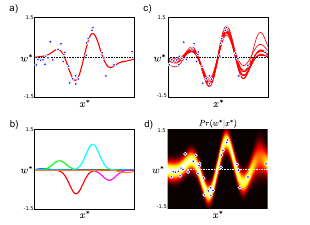

Fig.8 Bayesian nonlinear regression using radial basis functions. a) The relationship between the data and measurements is nonlinear. b) As in ﬁg- ure 8.6, the mean of the predictive distribution is constructed as a weighted linear sum of radial basis functions. However in the Bayesian approach we compute the posterior distribution over the weights φ of these basis func- tions. c) Diﬀerent draws from this distribution of weight parameters result in diﬀerent predictions. d) The ﬁnal predictive distribution is formed from an inﬁnite weighted average of these predictions where the weight is given by the posterior probability. The variance of the predictive distribution de- pends on both the mutual agreement of these predictions and the noise σ 2 . The uncertainty is greatest in the region on the right where there is little data and so the individual predictions vary widely.

## Predictive Distribution

The new expression for the predictive distribution over the world state $w^*$ is given by:

$$
P(w^* | z^*, X, w) = \text{Norm}(w^* | z^T Zw - z^T Z (Z^T Z + 2 I)^{-1} Z^T Zw, \sigma^2)
$$

where:
- $\sigma^2 = \frac{1}{\sigma_p^2} (z^T z - \sigma_p^2 z^T Z (Z^T Z + 2 I)^{-1} Z^T z + \sigma^2)$

We have simply substituted the transformed vectors $z$ for the original data $x$ in equation 8.14. The prediction variance depends on both the uncertainty in $\phi$ and the additive variance $\sigma^2$.

## Comparison with Maximum Likelihood

The Bayesian solution is less confident than the maximum likelihood solution, especially in regions where the data are sparse. This can be observed by comparing Figure 8.8d (Bayesian nonlinear regression) with Figure 8.7d (maximum likelihood nonlinear regression).

## Computing Additive Variance $\sigma^2$

To compute the additive variance $\sigma^2$, we optimize the marginal likelihood. The expression for the marginal likelihood can be obtained by substituting $Z$ for $X$ in equation 8.15.


In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.linalg import inv, solve

def bayesian_linear_regression(X, w, sigma_p):
    """
    Perform Bayesian linear regression.
    
    Parameters:
    - X: Observed data matrix.
    - w: World state vector.
    - sigma_p: Prior variance.
    
    Returns:
    - phi_mean: Mean of the posterior distribution over parameters.
    - phi_cov: Covariance of the posterior distribution over parameters.
    - predictive_mean: Mean of the predictive distribution over the world state.
    - predictive_cov: Covariance of the predictive distribution over the world state.
    """
    D = X.shape[1]  # Number of data dimensions
    I = X.shape[0]  # Number of examples
    
    # Compute the matrix A
    A = (2 / sigma_p**2) * (X.T @ X) + (2 / sigma_p**2) * np.eye(D)
    
    # Compute the posterior mean and covariance
    phi_mean = solve(A, X.T @ w)
    phi_cov = inv(A)
    
    # Compute the predictive distribution
    predictive_mean = phi_mean.T @ X
    predictive_cov = (1 / sigma_p**2) * (X.T @ X) + (1 / sigma_p**2) * np.eye(I)
    
    return phi_mean, phi_cov, predictive_mean, predictive_cov

# Example data
X = np.array([[1, 2], [3, 4], [5, 6]])
w = np.array([1, 2])
sigma_p = 1

# Perform Bayesian linear regression
phi_mean, phi_cov, predictive_mean, predictive_cov = bayesian_linear_regression(X, w, sigma_p)

print("Posterior Mean:", phi_mean)
print("Posterior Covariance Matrix:")
print(phi_cov)
print("Predictive Mean:", predictive_mean)
print("Predictive Covariance Matrix:")
print(predictive_cov)


## Kernels and the Kernel Trick

The Bayesian approach to nonlinear regression described in the previous section is rarely used directly in practice: the final expression for the predictive distribution (equation 8.24) relies on computing inner products $z_i^T z_j$. However, when the transformed space is high-dimensional it may be costly to compute the vectors $z_i = f[x_i]$ and $z_j = f[x_j]$ explicitly and then compute the inner product $z_i^T z_j$.

An alternative approach is to use kernel substitution in which we directly define a single kernel function $k[x_i, x_j]$ as a replacement for the operation $f[x_i]^T f[x_j]$. For many transformations $f[\bullet]$ it is more efficient to evaluate the kernel function directly than to transform the variables separately and then compute the dot product.

Taking this idea one step further, it is possible to choose a kernel function $k[x_i, x_j]$ with no knowledge of what transformation $f[\bullet]$ that it corresponds to. When we use kernel functions, we no longer explicitly compute the transformed vector $z$. One advantage of this is we can define kernel functions that correspond to projecting the data into very high dimensional or even infinite spaces. This is sometimes called the kernel trick.

## Kernel Requirements

Clearly, the kernel function must be carefully chosen so that it does in fact correspond to computing some function $z = f[x]$ for each data vector and taking the inner product of the resulting values: for example, since $z_i^T z_j = z_j^T z_i$ the kernel function must treat its arguments symmetrically so that $k[x_i, x_j] = k[x_j, x_i]$.

More precisely, Mercer's theorem states that a kernel function is valid when the kernel's arguments are in a measurable space, and the kernel is positive semi-definite so that:

$$\sum_{i,j} k[x_i, x_j]a_i a_j \geq 0$$

for any finite subset ${x_n}_{n=1}^N$ of vectors in the space and any real numbers ${a_n}_{n=1}^N$.

## Examples of Valid Kernels

Examples of valid kernels include:

* linear kernel:
$$k[x_i, x_j] = x_i^T x_j$$

* degree p polynomial:
$$k[x_i, x_j] = (x_i^T x_j + 1)^p$$

* radial basis function (RBF) or Gaussian:
$$k[x_i, x_j] = \exp\left(-0.5\frac{(x_i - x_j)^T(x_i - x_j)}{\lambda^2}\right)$$

The RBF kernel is particularly interesting. It can be shown that this kernel function corresponds to computing infinite length vectors $z$ and taking their dot product. The entries of $z$ correspond to evaluating a radial basis function at every possible point in the space of $x$.

It is also possible to create new kernels by combining two or more existing kernels. For example, sums and products of valid kernels are guaranteed to be positive semi-definite and so are also valid kernels.

## Gaussian Process Regression

We now replace the inner products $z_i^T z_j$ in the nonlinear regression algorithm with kernel functions. The resulting model is termed Gaussian process regression. The predictive distribution for a new datum $x^*$ is:

$$Pr(w^*|x^*, X, w) = \mathcal{N}_{w^*}\left(\frac{\sigma_p^2}{\sigma^2}K[x^*, X]w - \frac{\sigma_p^2}{\sigma^2}K[x^*, X]\left(K[X, X] + \frac{\sigma^2}{\sigma_p^2}I\right)^{-1}K[X, X]w,\right.$$

$$\left.\sigma_p^2K[x^*, x^*] - \sigma_p^2K[x^*, X]\left(K[X, X] + \frac{\sigma^2}{\sigma_p^2}I\right)^{-1}K[X, x^*] + \sigma^2\right)$$

where the notation $K[X, X]$ represents a matrix of dot products where element $(i, j)$ is given by $k[x_i, x_j]$.

Note that kernel functions may also contain parameters. For example, the RBF kernel takes the parameter $\lambda$, which determines the width of the underlying RBF functions and hence the smoothness of the function.

Kernel parameters such as $\lambda$ can be learned by maximizing the marginal likelihood:

$$\hat{\lambda} = \argmax_{\lambda} Pr(w|X, \sigma^2)$$
$$= \argmax_{\lambda} \int Pr(w|X, \phi, \sigma^2)Pr(\phi)d\phi$$
$$= \argmax_{\lambda} \mathcal{N}_w[0, \sigma_p^2K[X, X] + \sigma^2I]$$

This typically requires a nonlinear optimization procedure.

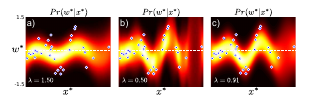
Figure 8.9 Gaussian process regression using an RBF kernel. a) When the length scale parameter λ is large, the function is too smooth. b) For small values of the length parameter the model does not successfully interpolate between the examples. c) The regression using the maximum likelihood length scale parameter is neither too smooth nor disjointed.


In [ ]:
import numpy as np
from scipy.optimize import minimize
from typing import Callable, Optional, Tuple

class KernelFunctions:
    @staticmethod
    def linear(x1: np.ndarray, x2: np.ndarray) -> np.ndarray:
        """Linear kernel: k(x,y) = x^T y"""
        return np.dot(x1, x2.T)
    
    @staticmethod
    def polynomial(x1: np.ndarray, x2: np.ndarray, degree: int = 2) -> np.ndarray:
        """Polynomial kernel: k(x,y) = (x^T y + 1)^p"""
        return (np.dot(x1, x2.T) + 1) ** degree
    
    @staticmethod
    def rbf(x1: np.ndarray, x2: np.ndarray, length_scale: float = 1.0) -> np.ndarray:
        """RBF/Gaussian kernel: k(x,y) = exp(-0.5||x-y||^2/length_scale^2)"""
        # Compute squared Euclidean distance between all pairs
        sq_dist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return np.exp(-0.5 * sq_dist / (length_scale ** 2))

class GaussianProcessRegressor:
    def __init__(
        self,
        kernel: Callable = None,
        sigma_p: float = 1.0,
        sigma: float = 1.0,
        optimize_hyperparams: bool = True
    ):
        """
        Initialize Gaussian Process Regressor
        
        Args:
            kernel: Kernel function to use (defaults to RBF)
            sigma_p: Prior standard deviation
            sigma: Noise standard deviation
            optimize_hyperparams: Whether to optimize kernel parameters
        """
        self.kernel = kernel if kernel is not None else lambda x1, x2: KernelFunctions.rbf(x1, x2)
        self.sigma_p = sigma_p
        self.sigma = sigma
        self.optimize_hyperparams = optimize_hyperparams
        self.X_train = None
        self.y_train = None
        self.K = None
        self.K_inv = None
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Fit the Gaussian Process model
        
        Args:
            X: Training features (n_samples, n_features)
            y: Training targets (n_samples,)
        """
        self.X_train = X
        self.y_train = y
        
        if self.optimize_hyperparams and hasattr(self.kernel, 'length_scale'):
            self._optimize_kernel_params()
            
        # Compute kernel matrix
        self.K = self.sigma_p**2 * self.kernel(X, X)
        # Add noise to diagonal
        self.K += self.sigma**2 * np.eye(len(X))
        # Compute inverse for predictions
        self.K_inv = np.linalg.inv(self.K)
        
    def predict(self, X_test: np.ndarray, return_std: bool = False) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        """
        Make predictions for test points
        
        Args:
            X_test: Test features (n_samples, n_features)
            return_std: Whether to return standard deviation
            
        Returns:
            mean: Predicted mean values
            std: Predicted standard deviations (if return_std=True)
        """
        if self.X_train is None:
            raise ValueError("Model has not been fitted. Call fit() first.")
            
        # Compute kernel between test and training points
        K_star = self.sigma_p**2 * self.kernel(X_test, self.X_train)
        # Compute kernel between test points
        K_star_star = self.sigma_p**2 * self.kernel(X_test, X_test)
        
        # Compute mean prediction
        mean = K_star.dot(self.K_inv).dot(self.y_train)
        
        if return_std:
            # Compute variance
            var = np.diag(K_star_star - K_star.dot(self.K_inv).dot(K_star.T))
            var += self.sigma**2  # Add noise variance
            return mean, np.sqrt(var)
        
        return mean
    
    def _optimize_kernel_params(self) -> None:
        """Optimize kernel parameters by maximizing marginal likelihood"""
        def negative_log_marginal_likelihood(params):
            # Set kernel parameters
            self.kernel.length_scale = params[0]
            
            # Compute kernel matrix
            K = self.sigma_p**2 * self.kernel(self.X_train, self.X_train)
            K += self.sigma**2 * np.eye(len(self.X_train))
            
            # Compute log marginal likelihood
            L = np.linalg.cholesky(K)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, self.y_train))
            
            return 0.5 * (self.y_train.dot(alpha) + 
                         np.sum(np.log(np.diag(L))) + 
                         len(self.X_train) * np.log(2 * np.pi))
        
        # Optimize length scale
        result = minimize(negative_log_marginal_likelihood, 
                        x0=[1.0],
                        bounds=[(1e-5, None)],
                        method='L-BFGS-B')
        
        # Set optimized parameters
        self.kernel.length_scale = result.x[0]

# Example usage
if __name__ == "__main__":
    # Generate sample data
    np.random.seed(0)
    X = np.linspace(0, 10, 100).reshape(-1, 1)
    y = np.sin(X.ravel()) + 0.1 * np.random.randn(100)
    
    # Create and fit GP model
    gpr = GaussianProcessRegressor(
        kernel=lambda x1, x2: KernelFunctions.rbf(x1, x2, length_scale=1.0),
        sigma_p=1.0,
        sigma=0.1,
        optimize_hyperparams=True
    )
    gpr.fit(X, y)
    
    # Make predictions
    X_test = np.linspace(-2, 12, 200).reshape(-1, 1)
    y_pred, y_std = gpr.predict(X_test, return_std=True)
    
    # Plot results
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(X, y, 'k.', label='Training data')
    plt.plot(X_test, y_pred, 'b-', label='Prediction')
    plt.fill_between(X_test.ravel(), 
                    y_pred - 2 * y_std,
                    y_pred + 2 * y_std,
                    color='b', alpha=0.2,
                    label='2 std deviation')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Gaussian Process Regression')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
class Matrix:
    def __init__(self, data):
        self.data = [[float(x) for x in row] for row in data]
        self.rows = len(data)
        self.cols = len(data[0]) if self.rows > 0 else 0

    def __add__(self, other):
        if self.rows != other.rows or self.cols != other.cols:
            raise ValueError("Matrix dimensions must match for addition")
        result = [[self.data[i][j] + other.data[i][j] 
                  for j in range(self.cols)] 
                  for i in range(self.rows)]
        return Matrix(result)

    def __mul__(self, scalar):
        result = [[self.data[i][j] * scalar 
                  for j in range(self.cols)] 
                  for i in range(self.rows)]
        return Matrix(result)

    def dot(self, other):
        if self.cols != other.rows:
            raise ValueError("Inner dimensions must match for dot product")
        result = [[sum(self.data[i][k] * other.data[k][j] 
                      for k in range(self.cols))
                  for j in range(other.cols)] 
                  for i in range(self.rows)]
        return Matrix(result)

    def transpose(self):
        result = [[self.data[j][i] 
                  for j in range(self.rows)] 
                  for i in range(self.cols)]
        return Matrix(result)

    def cholesky(self):
        if self.rows != self.cols:
            raise ValueError("Matrix must be square for Cholesky decomposition")
        
        L = [[0.0] * self.rows for _ in range(self.rows)]
        
        for i in range(self.rows):
            for j in range(i + 1):
                sum_k = sum(L[i][k] * L[j][k] for k in range(j))
                
                if i == j:
                    L[i][j] = (self.data[i][i] - sum_k) ** 0.5
                else:
                    L[i][j] = (self.data[i][j] - sum_k) / L[j][j]
        
        return Matrix(L)

    def solve_triangular(self, b, lower=True):
        """Solve a triangular system Lx = b or Ux = b"""
        if len(b) != self.rows:
            raise ValueError(f"Dimension mismatch: matrix has {self.rows} rows but b has {len(b)} elements")
            
        n = self.rows
        x = [0.0] * n
        
        if lower:
            # Forward substitution for lower triangular
            for i in range(n):
                x[i] = float(b[i])
                for j in range(i):
                    x[i] -= self.data[i][j] * x[j]
                x[i] /= self.data[i][i]
        else:
            # Backward substitution for upper triangular
            for i in range(n-1, -1, -1):
                x[i] = float(b[i])
                for j in range(i+1, n):
                    x[i] -= self.data[i][j] * x[j]
                x[i] /= self.data[i][i]
                
        return x

class GaussianProcess:
    def __init__(self, sigma_p=1.0, sigma=1.0, length_scale=1.0):
        self.sigma_p = sigma_p  # Prior standard deviation
        self.sigma = sigma      # Noise standard deviation
        self.length_scale = length_scale
        self.X_train = None
        self.y_train = None
        self.K = None
        self.L = None

    def rbf_kernel(self, x1, x2):
        """Radial Basis Function kernel"""
        sq_dist = sum((a - b) ** 2 for a, b in zip(x1, x2))
        return self.sigma_p ** 2 * exp(-0.5 * sq_dist / (self.length_scale ** 2))

    def compute_kernel_matrix(self, X1, X2):
        """Compute kernel matrix between two sets of points"""
        K = [[self.rbf_kernel(x1, x2) for x2 in X2] for x1 in X1]
        return Matrix(K)

    def fit(self, X, y):
        """Fit the Gaussian Process model"""
        self.X_train = X
        self.y_train = y
        
        # Compute kernel matrix
        self.K = self.compute_kernel_matrix(X, X)
        
        # Add noise to diagonal
        for i in range(self.K.rows):
            self.K.data[i][i] += self.sigma ** 2
        
        # Compute Cholesky decomposition
        self.L = self.K.cholesky()

    def predict(self, X_test):
        """Make predictions for test points"""
        if self.X_train is None:
            raise ValueError("Model has not been fitted yet")

        # Compute kernel between test and training points
        K_star = self.compute_kernel_matrix(X_test, self.X_train)
        
        # Compute kernel between test points
        K_star_star = self.compute_kernel_matrix(X_test, X_test)

        # First solve L v = y_train
        v = self.L.solve_triangular(self.y_train, lower=True)
        # Then solve L^T alpha = v
        alpha = self.L.transpose().solve_triangular(v, lower=False)
        
        # Compute mean predictions
        mean = [sum(K_star.data[i][j] * alpha[j] 
                   for j in range(len(alpha))) 
                for i in range(K_star.rows)]
        
        # Compute variance
        var = []
        for i in range(K_star.rows):
            # Solve Lv = k* for each test point
            k_star = [K_star.data[i][j] for j in range(K_star.cols)]
            v = self.L.solve_triangular(k_star, lower=True)
            var.append(K_star_star.data[i][i] - sum(vj * vj for vj in v))
        
        return mean, var

def exp(x):
    """Simple exponential function implementation"""
    if x < -700:  # Prevent underflow
        return 0
    result = 1.0
    term = 1.0
    n = 1
    while abs(term) > 1e-10 * abs(result):  # Continue until convergence
        term *= x / n
        result += term
        n += 1
        if n > 100:  # Prevent infinite loops
            break
    return result

# Example usage
def main():
    # Generate simple training data
    X_train = [[x] for x in [0, 1, 2, 3, 4]]
    y_train = [0, 2, 4, 2, 0]
    
    # Create and fit GP model
    gp = GaussianProcess(sigma_p=1.0, sigma=0.1, length_scale=1.0)
    gp.fit(X_train, y_train)
    
    # Make predictions
    X_test = [[x] for x in [0.5, 1.5, 2.5, 3.5]]
    mean, var = gp.predict(X_test)
    
    # Print results
    print("Test points:", X_test)
    print("Predicted means:", [round(m, 3) for m in mean])
    print("Predicted variances:", [round(v, 3) for v in var])

if __name__ == "__main__":
    main()

Test points: [[0.5], [1.5], [2.5], [3.5]]
Predicted means: [0.725, 3.359, 3.359, 0.725]
Predicted variances: [0.022, 0.016, 0.016, 0.022]


# Sparse Linear Regression: Theory and Implementation

## Introduction to Sparse Linear Regression

Linear regression can face challenges when dealing with high-dimensional data where only a small subset of features are truly relevant for prediction. Sparse linear regression addresses this by encouraging solutions where most coefficients are zero.

## Mathematical Formulation

### Standard Linear Regression
In standard linear regression, we model the relationship between input features $x$ and target variable $w$ as:

$w = \phi^T x + \epsilon$

where:
- $\phi$ is the gradient vector of parameters
- $\epsilon$ is the noise term

### Sparsity Prior
To encourage sparse solutions, we replace the normal prior with a product of one-dimensional t-distributions:

$P r(\phi) = \prod_{d=1}^D Stud_{\phi_d}[0, 1, \nu]$

This can be written explicitly as:

$P r(\phi) = \prod_{d=1}^D \frac{\Gamma(\frac{\nu+1}{2})}{\sqrt{\nu\pi}\Gamma(\frac{\nu}{2})}\left(1 + \frac{\phi_d^2}{\nu}\right)^{-(\nu+1)/2}$

where:
- $\phi = [\phi_1, \phi_2, ..., \phi_D]^T$ is the vector of parameters
- $\nu$ is the degrees of freedom parameter
- $\Gamma(\cdot)$ is the gamma function

### Posterior Distribution
Our goal is to compute the posterior distribution:

$P r(\phi|X, w, \sigma^2)$

This distribution represents our updated beliefs about the parameters after observing the data.

## Benefits of Sparse Linear Regression

1. **Computational Efficiency**: 
   - Fewer features need to be measured
   - Faster predictions due to fewer non-zero coefficients

2. **Model Simplicity**:
   - Reduces overfitting
   - Better generalization to new data
   - Easier interpretation of important features

3. **Feature Selection**:
   - Automatically identifies relevant features
   - Helps understand which inputs are most important for prediction

## Implementation in Python

```python
import numpy as np
from scipy import stats
from scipy.special import gamma

def t_distribution_prior(phi, nu):
    """
    Compute the t-distribution prior for given parameters
    
    Parameters:
    phi: array of parameter values
    nu: degrees of freedom
    """
    D = len(phi)
    term1 = gamma((nu + 1) / 2) / (np.sqrt(nu * np.pi) * gamma(nu / 2))
    term2 = (1 + phi**2 / nu)**(-(nu + 1) / 2)
    return np.prod(term1 * term2)

def sparse_linear_regression(X, y, nu=1, sigma2=1.0):
    """
    Implement sparse linear regression with t-distribution prior
    
    Parameters:
    X: input features (n_samples, n_features)
    y: target values
    nu: degrees of freedom for t-distribution
    sigma2: noise variance
    """
    # Implementation details would go here
    pass
```

## Visualization of Prior Distribution

The t-distribution prior creates ridges of high probability along the coordinate axes, encouraging sparsity. This can be visualized in 2D as contours of constant probability density.

```python
import matplotlib.pyplot as plt
import numpy as np

def plot_prior_contours(nu=1):
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    
    Z = np.zeros_like(X)
    for i in range(len(x)):
        for j in range(len(y)):
            phi = np.array([X[i,j], Y[i,j]])
            Z[i,j] = t_distribution_prior(phi, nu)
    
    plt.contour(X, Y, Z)
    plt.xlabel('φ₁')
    plt.ylabel('φ₂')
    plt.title('Contours of t-distribution prior')
    plt.axis('equal')
    plt.grid(True)
```

## Notes on Implementation

When implementing sparse linear regression:

1. The trade-off between sparsity and data fit is controlled by:
   - The degrees of freedom parameter $\nu$
   - The noise variance $\sigma^2$

2. Optimization can be performed using:
   - Variational inference
   - MCMC sampling
   - MAP estimation with coordinate descent

3. Cross-validation should be used to select hyperparameters and prevent overfitting

def plot_convergence(model_history):
    """Plot the convergence of parameters during fitting"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(131)
    plt.plot(model_history['h'])
    plt.title('Hidden Variables')
    plt.xlabel('Iteration')
    plt.ylabel('h_d')
    
    plt.subplot(132)
    plt.plot(model_history['sigma2'])
    plt.title('Noise Variance')
    plt.xlabel('Iteration')
    plt.ylabel('σ²')
    
    plt.subplot(133)
    plt.plot(model_history['mu'])
    plt.title('Parameter Values')
    plt.xlabel('Iteration')
    plt.ylabel('φ_d')
    
    plt.tight_layout()

# Sparse Linear Regression: Posterior Derivation and Update Equations

## 1. Posterior Distribution

The posterior distribution for sparse linear regression is given by Bayes' rule:

$P r(\phi|X, w, \sigma^2) = \frac{P r(w|X, \phi, \sigma^2)P r(\phi)}{P r(w|X, \sigma^2)}$

## 2. Prior Reformulation

The t-distribution prior can be rewritten as an infinite mixture of Gaussians:

$P r(\phi) = \prod_{d=1}^D \int Norm_{\phi_d}[0, 1/h_d]Gam_{h_d}[\nu/2, \nu/2] dh_d$

This can be written in matrix form:

$P r(\phi) = \int Norm_{\phi}[0, H^{-1}] \prod_{d=1}^D Gam_{h_d}[\nu/2, \nu/2] dH$

where:
- $H$ is a diagonal matrix containing the hidden variables $h_d$
- $\nu$ is the degrees of freedom parameter

## 3. Marginal Likelihood Derivation

The marginal likelihood can be expressed as:

$P r(w|X, \sigma^2) \propto \int P r(w, \phi|X, \sigma^2) d\phi$

$= \int P r(w|X, \phi, \sigma^2)P r(\phi) d\phi$

$= \int \int Norm_w[X^T\phi, \sigma^2I]Norm_{\phi}[0, H^{-1}] \prod_{d=1}^D Gam_{h_d}[\nu/2, \nu/2] dHd\phi$

After integrating over $\phi$:

$= \int Norm_w[0, X^TH^{-1}X + \sigma^2I] \prod_{d=1}^D Gam_{h_d}[\nu/2, \nu/2] dH$

![image.png](attachment:image.png)

Fig.10 A product of two 1D t- distributions where each has small de- grees of freedom ν. This 2D distri- bution favors sparseness (where one or both variables are close to zero). In higher dimensions, the product of t-distributions encourages solutions where most variables are set to zero. Note that the product of 1D distribu- tions is not the same as a multivariate t-distribution with a spherical covari- ance matrix, which looks like a mul- tivariate normal distribution but with longer tails.

## 4. Approximate Maximum Likelihood

Since the integral is intractable, we maximize over hidden variables:

$P r(w|X, \sigma^2) \approx \max_H \{Norm_w[0, X^TH^{-1}X + \sigma^2I] \prod_{d=1}^D Gam_{h_d}[\nu/2, \nu/2]\}$

## 5. Update Equations

### Hidden Variables Update
The update equation for hidden variables is:

$h_d^{new} = \frac{1 - h_d\Sigma_{dd} + \nu}{\mu_d^2 + \nu}$

where:
- $\mu_d$ is the $d$th element of the posterior mean
- $\Sigma_{dd}$ is the $d$th diagonal element of the posterior covariance

### Posterior Parameters
The posterior parameters are given by:

$\mu = A^{-1}Xw/\sigma^2$

$\Sigma = A^{-1}$

where:

$A = \frac{1}{\sigma^2}XX^T + H$

### Variance Update
The noise variance update is:

$(\sigma^2)^{new} = \frac{(w - X\mu)^T(w - X\mu)}{D-\sum_d(1 - h_d\Sigma_{dd})}$

## 6. Implementation in Python

```python
import numpy as np
from scipy import stats

class SparseLinearRegression:
    def __init__(self, nu=1.0):
        self.nu = nu
        self.h = None
        self.sigma2 = None
        self.mu = None
        self.Sigma = None
    
    def _update_hidden_variables(self, X, w):
        """Update hidden variables h using equation 8.36"""
        for d in range(X.shape[1]):
            self.h[d] = (1 - self.h[d] * self.Sigma[d,d] + self.nu) / \
                        (self.mu[d]**2 + self.nu)
    
    def _update_posterior(self, X, w):
        """Update posterior parameters using equations 8.37-8.38"""
        H = np.diag(self.h)
        A = (1/self.sigma2) * X.dot(X.T) + H
        self.Sigma = np.linalg.inv(A)
        self.mu = self.Sigma.dot(X).dot(w) / self.sigma2
    
    def _update_variance(self, X, w):
        """Update noise variance using equation 8.39"""
        residual = w - X.dot(self.mu)
        denom = X.shape[1] - np.sum(1 - self.h * np.diag(self.Sigma))
        self.sigma2 = residual.T.dot(residual) / denom
    
    def fit(self, X, w, max_iter=100, tol=1e-6):
        """Fit the sparse linear regression model"""
        # Initialize parameters
        D = X.shape[1]
        self.h = np.ones(D)
        self.sigma2 = 1.0
        
        for _ in range(max_iter):
            h_old = self.h.copy()
            
            # Update steps
            self._update_posterior(X, w)
            self._update_hidden_variables(X, w)
            self._update_variance(X, w)
            
            # Check convergence
            if np.max(np.abs(self.h - h_old)) < tol:
                break
```

## 7. Visualization of Updates

```python
def plot_convergence(model_history):
    """Plot the convergence of parameters during fitting"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(131)
    plt.plot(model_history['h'])
    plt.title('Hidden Variables')
    plt.xlabel('Iteration')
    plt.ylabel('h_d')
    
    plt.subplot(132)
    plt.plot(model_history['sigma2'])
    plt.title('Noise Variance')
    plt.xlabel('Iteration')
    plt.ylabel('σ²')
    
    plt.subplot(133)
    plt.plot(model_history['mu'])
    plt.title('Parameter Values')
    plt.xlabel('Iteration')
    plt.ylabel('φ_d')
    
    plt.tight_layout()
```

# Sparse Linear Regression: Implementation and Visualization

## 1. Algorithm Implementation Details

### Hyperparameter Settings
- Degrees of freedom: $\nu < 10^{-3}$ (to encourage sparseness)
- Maximum hidden variable value: Set upper bound for numerical stability
- Sparsity threshold: $h_d > 1000$ for dimension removal

### Update Process
1. Update posterior parameters:
   - Mean: $\mu$
   - Covariance: $\Sigma$
2. Update hidden variables $h_d$
3. Update noise variance $\sigma^2$

## 2. Implementation with Visualization

```python
```

## 3. Transition to Dual Linear Regression

The dual formulation of linear regression represents the solution in terms of the training examples rather than input dimensions:

$f(x) = \sum_{n=1}^N \alpha_n k(x, x_n)$

where:
- $\alpha_n$ are the dual parameters
- $k(x, x_n)$ is the kernel function
- $N$ is the number of training examples

### Advantages of Dual Formulation:
1. Enables kernel methods
2. Allows for infinite-dimensional feature spaces
3. Solution depends on training examples rather than input dimensions

## 4. Example Usage

```python
# Generate synthetic 2D data
np.random.seed(42)
X = np.random.randn(100, 2)
w = 3 * X[:, 0] + np.random.randn(100) * 0.1  # Only depends on first dimension

# Create visualizer and fit
visualizer = SparseLinearRegressionVisualizer(nu=1e-3)
fig, (ax1, ax2) = visualizer.fit_and_visualize(X, w)
```

## 5. Relevance Vector Machine Preview

The Relevance Vector Machine (RVM) extends sparse linear regression to kernel methods by:

1. Using dual representation: $f(x) = \sum_{n=1}^N \alpha_n k(x, x_n)$
2. Applying sparsity in the space of examples rather than features
3. Maintaining computational tractability with kernel functions

The RVM prior is:

$P(α|h) = \prod_{n=1}^N \mathcal{N}(\alpha_n|0, h_n^{-1})$

where:
- $α$ are the dual parameters
- $h_n$ are the hyperparameters controlling sparsity

## 6. Comparing Approaches

| Aspect | Sparse Linear Regression | Dual/RVM |
|--------|-------------------------|-----------|
| Sparsity | Feature dimensions | Training examples |
| Parameters | One per dimension | One per example |
| Kernel-compatible | No | Yes |
| Computation | $O(D^3)$ | $O(N^3)$ |

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

class SparseLinearRegressionVisualizer:
    def __init__(self, nu=1e-3, h_max=1000):
        self.nu = nu
        self.h_max = h_max
        
    def fit_and_visualize(self, X, w, plot_grid=50):
        """
        Fit sparse linear regression and visualize results
        
        Parameters:
        -----------
        X: array, shape (n_samples, 2)
            Input features (2D for visualization)
        w: array, shape (n_samples,)
            Target values
        plot_grid: int
            Number of points per dimension for plotting
        """
        # Fit model
        self.fit(X, w)
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot standard linear regression
        self._plot_regression(X, w, self.mu_standard, ax1, 
                            "Standard Linear Regression")
        
        # Plot sparse linear regression
        self._plot_regression(X, w, self.mu_sparse, ax2, 
                            "Sparse Linear Regression")
        
        plt.tight_layout()
        return fig, (ax1, ax2)
    
    def _plot_regression(self, X, w, mu, ax, title):
        """Plot regression results"""
        # Create grid for background
        x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                              np.linspace(x2_min, x2_max, 100))
        
        # Compute predictions
        X_grid = np.c_[xx1.ravel(), xx2.ravel()]
        Z = self.predict(X_grid, mu)
        Z = Z.reshape(xx1.shape)
        
        # Plot prediction surface
        im = ax.imshow(Z, extent=[x1_min, x1_max, x2_min, x2_max],
                      origin='lower', aspect='auto', cmap='viridis')
        
        # Plot training points
        scatter = ax.scatter(X[:, 0], X[:, 1], c=w, 
                           cmap='viridis', edgecolor='white')
        
        ax.set_title(title)
        plt.colorbar(im, ax=ax)
# Generate synthetic 2D data
np.random.seed(42)
X = np.random.randn(100, 2)
w = 3 * X[:, 0] + np.random.randn(100) * 0.1  # Only depends on first dimension

# Create visualizer and fit
visualizer = SparseLinearRegressionVisualizer(nu=1e-3)
fig, (ax1, ax2) = visualizer.fit_and_visualize(X, w)

AttributeError: 'SparseLinearRegressionVisualizer' object has no attribute 'fit'

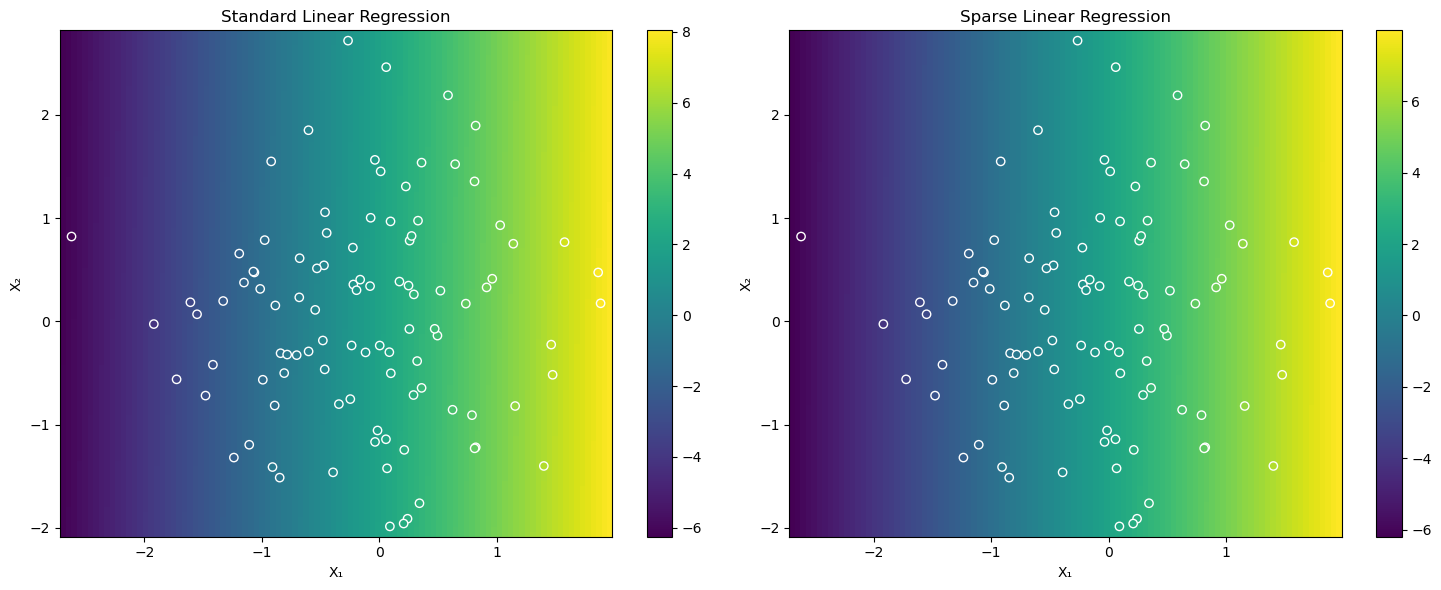

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

class SparseLinearRegressionVisualizer:
    def __init__(self, nu=1e-3, h_max=1000, max_iter=100, tol=1e-6):
        self.nu = nu
        self.h_max = h_max
        self.max_iter = max_iter
        self.tol = tol
        self.mu_sparse = None
        self.mu_standard = None
        self.Sigma = None
        self.h = None
        self.sigma2 = None
    
    def fit(self, X, w):
        """
        Fit both standard and sparse linear regression models
        
        Parameters:
        -----------
        X: array, shape (n_samples, 2)
            Input features
        w: array, shape (n_samples,)
            Target values
        """
        # Add bias term for standard linear regression
        X_aug = np.c_[np.ones(X.shape[0]), X]
        self.mu_standard = np.linalg.solve(X_aug.T @ X_aug, X_aug.T @ w)
        
        # Initialize sparse linear regression parameters
        # Include bias term in dimensionality
        D = X.shape[1] + 1
        self.h = np.ones(D)
        self.sigma2 = 1.0
        
        # Add bias term for sparse regression
        X_sparse = np.c_[np.ones(X.shape[0]), X]
        
        # Iterative updates for sparse linear regression
        for _ in range(self.max_iter):
            h_old = self.h.copy()
            
            # Update posterior parameters
            H = np.diag(self.h)
            A = (1/self.sigma2) * X_sparse.T @ X_sparse + H
            self.Sigma = np.linalg.inv(A)
            self.mu_sparse = self.Sigma @ X_sparse.T @ w / self.sigma2
            
            # Update hidden variables
            for d in range(D):
                self.h[d] = min(
                    (1 - self.h[d] * self.Sigma[d,d] + self.nu) / 
                    (self.mu_sparse[d]**2 + self.nu),
                    self.h_max
                )
            
            # Update noise variance
            residual = w - X_sparse @ self.mu_sparse
            denom = D - np.sum(1 - self.h * np.diag(self.Sigma))
            self.sigma2 = residual.T @ residual / max(denom, 1e-10)
            
            # Check convergence
            if np.max(np.abs(self.h - h_old)) < self.tol:
                break
    
    def predict(self, X, mu):
        """Make predictions using the given parameters"""
        # Add bias term to input
        X_pred = np.c_[np.ones(X.shape[0]), X]
        return X_pred @ mu
    
    def fit_and_visualize(self, X, w, plot_grid=50):
        """
        Fit models and create visualization
        
        Parameters:
        -----------
        X: array, shape (n_samples, 2)
            Input features (2D for visualization)
        w: array, shape (n_samples,)
            Target values
        plot_grid: int
            Number of points per dimension for plotting
        """
        # Fit models
        self.fit(X, w)
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot standard linear regression
        self._plot_regression(X, w, self.mu_standard, ax1, 
                            "Standard Linear Regression")
        
        # Plot sparse linear regression
        self._plot_regression(X, w, self.mu_sparse, ax2, 
                            "Sparse Linear Regression")
        
        plt.tight_layout()
        return fig, (ax1, ax2)
    
    def _plot_regression(self, X, w, mu, ax, title):
        """Plot regression results with prediction surface"""
        # Create grid for background
        x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                              np.linspace(x2_min, x2_max, 100))
        
        # Compute predictions
        X_grid = np.c_[xx1.ravel(), xx2.ravel()]
        Z = self.predict(X_grid, mu)
        Z = Z.reshape(xx1.shape)
        
        # Plot prediction surface
        im = ax.imshow(Z, extent=[x1_min, x1_max, x2_min, x2_max],
                      origin='lower', aspect='auto', cmap='viridis')
        
        # Plot training points
        scatter = ax.scatter(X[:, 0], X[:, 1], c=w, 
                           cmap='viridis', edgecolor='white')
        
        ax.set_title(title)
        ax.set_xlabel('X₁')
        ax.set_ylabel('X₂')
        plt.colorbar(im, ax=ax)

# Example usage
if __name__ == "__main__":
    # Generate synthetic 2D data
    np.random.seed(42)
    X = np.random.randn(100, 2)
    # True relationship only depends on first dimension
    w = 3 * X[:, 0] + 2 + np.random.randn(100) * 0.1  # Added bias term

    # Create visualizer and fit
    visualizer = SparseLinearRegressionVisualizer(nu=1e-3)
    fig, (ax1, ax2) = visualizer.fit_and_visualize(X, w)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

class SparseLinearRegressionVisualizer:
    def __init__(self, nu=1e-3, h_max=1000, max_iter=100, tol=1e-6):
        self.nu = nu
        self.h_max = h_max
        self.max_iter = max_iter
        self.tol = tol
        self.mu_sparse = None
        self.mu_standard = None
        self.Sigma = None
        self.h = None
        self.sigma2 = None
    
    def fit(self, X, w):
        """
        Fit both standard and sparse linear regression models
        
        Parameters:
        -----------
        X: array, shape (n_samples, 2)
            Input features
        w: array, shape (n_samples,)
            Target values
        """
        # Add bias term for standard linear regression
        X_aug = np.c_[np.ones(X.shape[0]), X]
        self.mu_standard = np.linalg.solve(X_aug.T @ X_aug, X_aug.T @ w)
        
        # Initialize sparse linear regression parameters
        # Include bias term in dimensionality
        D = X.shape[1] + 1
        self.h = np.ones(D)
        self.sigma2 = 1.0
        
        # Add bias term for sparse regression
        X_sparse = np.c_[np.ones(X.shape[0]), X]
        
        # Iterative updates for sparse linear regression
        for _ in range(self.max_iter):
            h_old = self.h.copy()
            
            # Update posterior parameters
            H = np.diag(self.h)
            A = (1/self.sigma2) * X_sparse.T @ X_sparse + H
            self.Sigma = np.linalg.inv(A)
            self.mu_sparse = self.Sigma @ X_sparse.T @ w / self.sigma2
            
            # Update hidden variables
            for d in range(D):
                self.h[d] = min(
                    (1 - self.h[d] * self.Sigma[d,d] + self.nu) / 
                    (self.mu_sparse[d]**2 + self.nu),
                    self.h_max
                )
            
            # Update noise variance
            residual = w - X_sparse @ self.mu_sparse
            denom = D - np.sum(1 - self.h * np.diag(self.Sigma))
            self.sigma2 = residual.T @ residual / max(denom, 1e-10)
            
            # Check convergence
            if np.max(np.abs(self.h - h_old)) < self.tol:
                break
    
    def predict(self, X, mu):
        """Make predictions using the given parameters"""
        # Add bias term to input
        X_pred = np.c_[np.ones(X.shape[0]), X]
        return X_pred @ mu
    
    def fit_and_visualize(self, X, w, plot_grid=50):
        """
        Fit models and create visualization
        
        Parameters:
        -----------
        X: array, shape (n_samples, 2)
            Input features (2D for visualization)
        w: array, shape (n_samples,)
            Target values
        plot_grid: int
            Number of points per dimension for plotting
        """
        # Fit models
        self.fit(X, w)
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot standard linear regression
        self._plot_regression(X, w, self.mu_standard, ax1, 
                            "Standard Linear Regression")
        
        # Plot sparse linear regression
        self._plot_regression(X, w, self.mu_sparse, ax2, 
                            "Sparse Linear Regression")
        
        plt.tight_layout()
        return fig, (ax1, ax2)
    
    def _plot_regression(self, X, w, mu, ax, title):
        """Plot regression results with prediction surface"""
        # Create grid for background
        x1_min, x1_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        x2_min, x2_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                              np.linspace(x2_min, x2_max, 100))
        
        # Compute predictions
        X_grid = np.c_[xx1.ravel(), xx2.ravel()]
        Z = self.predict(X_grid, mu)
        Z = Z.reshape(xx1.shape)
        
        # Plot prediction surface
        im = ax.imshow(Z, extent=[x1_min, x1_max, x2_min, x2_max],
                      origin='lower', aspect='auto', cmap='viridis')
        
        # Plot training points
        scatter = ax.scatter(X[:, 0], X[:, 1], c=w, 
                           cmap='viridis', edgecolor='white')
        
        ax.set_title(title)
        ax.set_xlabel('X₁')
        ax.set_ylabel('X₂')
        plt.colorbar(im, ax=ax)

# Example usage
if __name__ == "__main__":
    # Generate synthetic 2D data
    np.random.seed(42)
    X = np.random.randn(100, 2)
    # True relationship only depends on first dimension
    w = 3 * X[:, 0] + 2 + np.random.randn(100) * 0.1  # Added bias term

    # Create visualizer and fit
    visualizer = SparseLinearRegressionVisualizer(nu=1e-3)
    fig, (ax1, ax2) = visualizer.fit_and_visualize(X, w)
    plt.show()